<a href="https://colab.research.google.com/github/BuddhikaRoshan/Deep-Learning-Assignment/blob/sonaliliyanahetti-patch-1/IT22592088.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chest X-ray lung cancer image classification task. This approach utilizes the ResNet50 architecture for Transfer Learning after performing essential data preprocessing, including extraction, resizing, and splitting the dataset into training and validation** **sets** **bold text** **bold text** **bold text** **bold text**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

**Data Extraction**

In [4]:
dataset_url = '/content/drive/MyDrive/DL/lung_images.zip'


from zipfile import ZipFile #to extract .zip files.
import os

#Opens the ZIP file from Drive and extracts all images into
#a folder named 'lung_images'.
with ZipFile(dataset_url,'r') as zip:
  zip.extractall()
print('The data set has been extracted')

The data set has been extracted


**Data Preparation**

In [5]:
path ='lung_images'#unzipped folder name
classes=['lung_n','lung_aca']
 #two classes,
#lung_n → normal lungs
#lung_aca → lungs with adenocarcinoma (cancer)#binary classification

In [6]:
Img_Size=256 #pixel size
Split=0.2 #20% for validation
epochs=20 #train upto
Batch_size=64 #64 images are processed per training step

In [7]:
import cv2
import glob
#loading and preprocess data

x,y = [], [] #pixel value,class numbers

#loop through class
for i,cate in enumerate(classes):#enumerate: built in function to get both value and index no
  #glob-find all image paths in each class folder.
  images= glob.glob(f'{path}/{cate}/*.jpeg')
  for image in images:
    #read images using OpenCV
    #It converts the image file into a NumPy array of pixel values
    img= cv2.imread(image)
    img=cv2.resize(img,(Img_Size,Img_Size))
    x.append(img)# add actual pixel data
    y.append(i) #adds the label

**Normalize and End-hot coding**

In [8]:
import pandas as pd
import numpy as np

#convert lists into Numpy arrays by np.asarray() becausedeep learning models expect numpy arrays,not python lists
X = np.asarray(x) / 255.0  # normalize
Y = np.asarray(y)
one_hot_encoded_Y = pd.get_dummies(y).values

# **Split into train and Validation**

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=Split, random_state=2022)

**Compute class weight**

In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


# **Define and build the Resnet Block**

In [11]:
def resnet_block(inputs, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut
    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


In [12]:
inputs = keras.Input(shape=(Img_Size, Img_Size, 3))


In [13]:
x = layers.Conv2D(32, (7, 7), strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)


In [14]:
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 128, stride=2)
x = resnet_block(x, 128)
x = resnet_block(x, 256, stride=2)
x = resnet_block(x, 256)


In [15]:
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation='softmax')(x)


In [16]:
model = keras.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 2,801,730 (10.69 MB)

 Trainable params: 2,797,186 (10.67 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [17]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy reached 90%. Stopping training.')
            self.model.stop_training = True


In [19]:

es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **Train the Model**

In [21]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=Batch_size,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[es, lr, myCallback()],
    verbose=1
)



Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 305s 19s/step - accuracy: 0.8467 - loss: 0.4040 - val_accuracy: 0.5000 - val_loss: 12.2915 - learning_rate: 0.0010
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 295s 20s/step - accuracy: 0.9863 - loss: 0.0483 - val_accuracy: 0.5125 - val_loss: 4.0811 - learning_rate: 0.0010
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 316s 19s/step - accuracy: 0.9793 - loss: 0.0510 - val_accuracy: 0.6250 - val_loss: 0.8367 - learning_rate: 0.0010
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 319s 19s/step - accuracy: 0.9956 - loss: 0.0200 - val_accuracy: 0.5667 - val_loss: 1.2479 - learning_rate: 0.0010
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 325s 19s/step - accuracy: 0.9725 - loss: 0.0860 - val_accuracy: 0.5000 - val_loss: 1.9010 - learning_rate: 0.0010
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9893 - loss: 0.0282 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15/15 ━━━━━━━━━━━━━━━━━━━━ 289s 19s/step - accuracy: 0.9894 - loss: 0.0283 - v

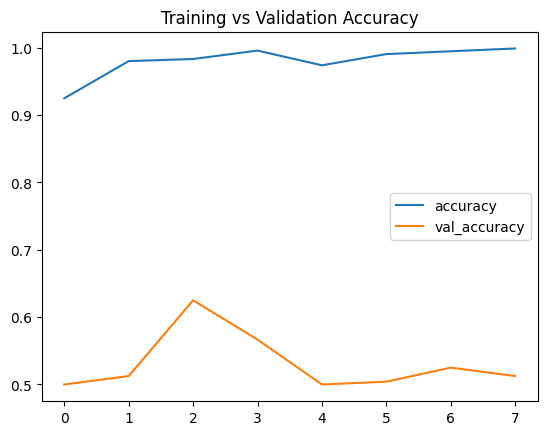

In [22]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Training vs Validation Accuracy')
plt.show()


In [23]:
from sklearn import metrics
Y_pred = model.predict(X_val)
Y_val_cls = np.argmax(Y_val, axis=1)
Y_pred_cls = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val_cls, Y_pred_cls, target_names=classes))

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step
              precision    recall  f1-score   support

      lung_n       0.57      1.00      0.73       120
    lung_aca       1.00      0.25      0.40       120

    accuracy                           0.62       240
   macro avg       0.79      0.62      0.56       240
weighted avg       0.79      0.62      0.56       240

